In [1]:
import datetime
import operator
import os
import sqlite3
from typing import Annotated, Sequence, TypedDict

from IPython.display import Image
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages

In [2]:
class GraphState(TypedDict):
    last_executed_node: str
    # Use Annotated[int, operator.add] to specify that 'step_counter'
    # should be accumulated (added to) rather than overwritten.
    step_counter: Annotated[int, operator.add]
    # Use Annotated[Sequence[str], add_messages] to append messages
    history: Annotated[Sequence[str], add_messages]
    last_update_time: str

In [3]:
def start_node(state: GraphState) -> dict:
    """Executes Start Node logic."""
    timestamp = datetime.datetime.now().isoformat()
    print(f"Executing Start Node")
    print(
        f"  Incoming state: step_counter={state['step_counter']}, last_node={state.get('last_executed_node', 'None')}"
    )
    message = f"  Visited Start at {timestamp}"
    # Return the updates to the state
    return {
        "last_executed_node": "StartNode",
        "step_counter": 1,  # Add 1 to the counter
        "history": [message],  # Append this message to history
        "last_update_time": timestamp,
    }


def cycle_node(state: GraphState) -> dict:
    """Executes Cycle Node logic."""
    timestamp = datetime.datetime.now().isoformat()
    print(f"Executing Cycle Node")
    print(
        f"  Incoming state: step_counter={state['step_counter']}, last_node={state.get('last_executed_node', 'None')}"
    )
    message = f"  Visited Cycle at {timestamp}"
    # Return the updates to the state
    return {
        "last_executed_node": "CycleNode",
        "step_counter": 1,  # Add 1 to the counter
        "history": [message],  # Append this message to history
        "last_update_time": timestamp,
    }

In [4]:
MAX_STEPS = 3


def should_loop(state: GraphState) -> str:
    """Determines if the loop should continue based on the step counter."""
    print(f"Checking Condition: step_counter = {state['step_counter']}")
    if state["step_counter"] < MAX_STEPS:
        print(f"  Condition TRUE (steps < {MAX_STEPS}), looping back to StartNode.")
        return "continue_loop"
    else:
        print(f"  Condition FALSE (steps >= {MAX_STEPS}), ending graph execution.")
        return "end_loop"

In [5]:
# Use the GraphState as the state schema
builder = StateGraph(GraphState)

# Add the nodes to the graph
builder.add_node("StartNode", start_node)
builder.add_node("CycleNode", cycle_node)

# Set the entry point for the graph
builder.set_entry_point("StartNode")

# Define the edges connecting the nodes
builder.add_edge("StartNode", "CycleNode")

# Add a conditional edge from CycleNode:
# Based on the output of 'should_loop', go to 'StartNode' or END.
builder.add_conditional_edges(
    "CycleNode",
    should_loop,
    {
        "continue_loop": "StartNode",  # If should_loop returns "continue_loop"
        "end_loop": END,  # If should_loop returns "end_loop"
    },
);

In [6]:
DB_NAME = "memory.db"

if os.path.exists(DB_NAME):
    os.remove(DB_NAME)

conn = sqlite3.connect(DB_NAME, check_same_thread=False)
checkpointer = SqliteSaver(conn=conn)

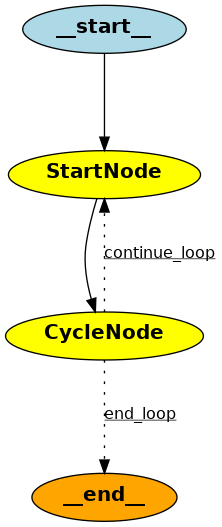

In [7]:
graph = builder.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_png()))

In [8]:
INITIAL_THREAD_ID = "initial-thread"
BRANCHING_THREAD_ID = "branching-thread"

# Define the configuration for the specific execution thread
thread_config = {"configurable": {"thread_id": INITIAL_THREAD_ID}}
# Initial state to start the graph
initial_state = {"step_counter": 0, "history": ["Initial State"]}

# Invoke the graph. It will run until it hits the END state.
# The checkpointer automatically saves state at each step.
final_state = graph.invoke(initial_state, config=thread_config)
final_state

Executing Start Node
  Incoming state: step_counter=0, last_node=None
Executing Cycle Node
  Incoming state: step_counter=1, last_node=StartNode
Checking Condition: step_counter = 2
  Condition TRUE (steps < 3), looping back to StartNode.
Executing Start Node
  Incoming state: step_counter=2, last_node=CycleNode
Executing Cycle Node
  Incoming state: step_counter=3, last_node=StartNode
Checking Condition: step_counter = 4
  Condition FALSE (steps >= 3), ending graph execution.


{'last_executed_node': 'CycleNode',
 'step_counter': 4,
 'history': [HumanMessage(content='Initial State', additional_kwargs={}, response_metadata={}, id='b037073a-16e9-40d6-9eae-62241182bd91'),
  HumanMessage(content='  Visited Start at 2025-04-25T08:47:59.762387', additional_kwargs={}, response_metadata={}, id='1df8596d-744d-40ab-ad1f-6e71806fb11a'),
  HumanMessage(content='  Visited Cycle at 2025-04-25T08:47:59.764044', additional_kwargs={}, response_metadata={}, id='6595097d-b222-4164-8625-2b2f3a8bac1c'),
  HumanMessage(content='  Visited Start at 2025-04-25T08:47:59.765354', additional_kwargs={}, response_metadata={}, id='5155f16b-ad90-41ba-bc67-f2ec6bdd76e5'),
  HumanMessage(content='  Visited Cycle at 2025-04-25T08:47:59.766432', additional_kwargs={}, response_metadata={}, id='d9ef5694-b838-4b8d-8049-679854870304')],
 'last_update_time': '2025-04-25T08:47:59.766432'}

In [9]:
# Retrieve the history of states for the thread
# History is returned most recent first.
state_history = list(graph.get_state_history(thread_config))  # Convert iterator to list
len(state_history)

6

In [10]:
# Store configs for later use (reversing to get chronological order for easier indexing)
state_configs_chronological = [state.config for state in reversed(state_history)]

# Print history in chronological order (oldest first)
for i, state in enumerate(reversed(state_history)):
    print(f"\nSnapshot {i}:")
    print(f"  Config: {state.config}")
    print(
        f"  Values: step_counter={state.values['step_counter']}, last_node={state.values.get('last_executed_node')}, time={state.values.get('last_update_time')}"
    )


Snapshot 0:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-daeb-63bf-bfff-752bb0118288'}}
  Values: step_counter=0, last_node=None, time=None

Snapshot 1:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db09-6148-8000-cc3f4d15c419'}}
  Values: step_counter=0, last_node=None, time=None

Snapshot 2:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db0c-6c6e-8001-2b6899ecd811'}}
  Values: step_counter=1, last_node=StartNode, time=2025-04-25T08:47:59.762387

Snapshot 3:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db10-6065-8002-310c33480833'}}
  Values: step_counter=2, last_node=CycleNode, time=2025-04-25T08:47:59.764044

Snapshot 4:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db12-6761-8003

In [11]:
branch_point_config = state_configs_chronological[
    2
]  # Config after first CycleNode execution

# Get the full state details at this branch point
branch_state = graph.get_state(branch_point_config)
branch_state.values

{'last_executed_node': 'StartNode',
 'step_counter': 1,
 'history': [HumanMessage(content='Initial State', additional_kwargs={}, response_metadata={}, id='b037073a-16e9-40d6-9eae-62241182bd91'),
  HumanMessage(content='  Visited Start at 2025-04-25T08:47:59.762387', additional_kwargs={}, response_metadata={}, id='1df8596d-744d-40ab-ad1f-6e71806fb11a')],
 'last_update_time': '2025-04-25T08:47:59.762387'}

In [12]:
branch_state.next

('CycleNode',)

In [13]:
branched_final_state = graph.invoke(None, config=branch_point_config)

Executing Cycle Node
  Incoming state: step_counter=1, last_node=StartNode
Checking Condition: step_counter = 2
  Condition TRUE (steps < 3), looping back to StartNode.
Executing Start Node
  Incoming state: step_counter=2, last_node=CycleNode
Executing Cycle Node
  Incoming state: step_counter=3, last_node=StartNode
Checking Condition: step_counter = 4
  Condition FALSE (steps >= 3), ending graph execution.


In [14]:
branched_final_state

{'last_executed_node': 'CycleNode',
 'step_counter': 4,
 'history': [HumanMessage(content='Initial State', additional_kwargs={}, response_metadata={}, id='b037073a-16e9-40d6-9eae-62241182bd91'),
  HumanMessage(content='  Visited Start at 2025-04-25T08:47:59.762387', additional_kwargs={}, response_metadata={}, id='1df8596d-744d-40ab-ad1f-6e71806fb11a'),
  HumanMessage(content='  Visited Cycle at 2025-04-25T08:47:59.898098', additional_kwargs={}, response_metadata={}, id='fd1f149b-48dc-4f66-9c65-ed46817188bc'),
  HumanMessage(content='  Visited Start at 2025-04-25T08:47:59.906790', additional_kwargs={}, response_metadata={}, id='42a60b57-4900-4f2f-bd08-7ed59fe25813'),
  HumanMessage(content='  Visited Cycle at 2025-04-25T08:47:59.912126', additional_kwargs={}, response_metadata={}, id='0b0a8f18-d634-4f5f-a5e3-a72c55367d80')],
 'last_update_time': '2025-04-25T08:47:59.912126'}

In [15]:
# Fetch history again - it will now include the original run and the branched run.
updated_history = list(graph.get_state_history(thread_config))

In [16]:
# Print history in chronological order (oldest first)
for i, state in enumerate(reversed(updated_history)):
    print(f"\nSnapshot {i}:")
    print(f"  Config: {state.config}")
    print(
        f"  Values: step_counter={state.values['step_counter']}, last_node={state.values.get('last_executed_node')}, time={state.values.get('last_update_time')}"
    )


Snapshot 0:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-daeb-63bf-bfff-752bb0118288'}}
  Values: step_counter=0, last_node=None, time=None

Snapshot 1:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db09-6148-8000-cc3f4d15c419'}}
  Values: step_counter=0, last_node=None, time=None

Snapshot 2:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db0c-6c6e-8001-2b6899ecd811'}}
  Values: step_counter=1, last_node=StartNode, time=2025-04-25T08:47:59.762387

Snapshot 3:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db10-6065-8002-310c33480833'}}
  Values: step_counter=2, last_node=CycleNode, time=2025-04-25T08:47:59.764044

Snapshot 4:
  Config: {'configurable': {'thread_id': 'initial-thread', 'checkpoint_ns': '', 'checkpoint_id': '1f021b1f-db12-6761-8003